# Обучение языковой модели с помощью LSTM

В задании обучены языковые модели с помощью рекуррентной нейронной сети. Работа велась с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string
from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря

1. Разделим отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставим только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитаем частоту вхождения каждого слова в оставшихся предложениях. Для деления предложения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создадим объект ```vocab``` класса ```set```, положиим в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
sentences = []
word_threshold = 32 #120

# токенизируем и отбрасываем те предложения, длина которых больше 32
# sent_tokenize разделяет текст на отдельные предложения

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(word_tokenize(x)) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 198756


In [ ]:
# частота встречаемости каждого слова в словаре
words = Counter()

# word_tokenize - токенизация текста на слова
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1
len(words)

  0%|          | 0/198756 [00:00<?, ?it/s]

69757

Добавим в словарь ```vocab_size=40000``` самых встречающихся слов.

In [ ]:
# создание словаря (начинаем со служебных токенов)

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
# Наполнение словаря
vocab.update(set([word[0] for word in words.most_common(vocab_size)]))

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета
Подготовка датасета и даталоадеров.

В классе ```WordDataset``` реализован метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода добавлены служебные токены начала и конца последовательности, а также токенизированы соответствующее предложения с помощью ```word_tokenize``` и сопоставлены ему индексы из ```word2ind```.

In [ ]:
# словари для конвертации индексов в буквы и обратно

# сопоставляет каждое слово из словаря vocab с его индексом
word2ind = {char: i for i, char in enumerate(vocab)}
# возвращает пары (индекс, слово) для каждого слова в vocab
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
"""
  # возвращает текенизированную версию предложения с индексом idx из набора данных:
  # 1. cтавит индексы символов bos_id, eos_id в начало и конец посл-ти
  # 2. токенизация - преобразование слова в индекс (.get), если буква неизвестная-ставим айди неизвестного токена
"""
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>'] # символ неизвестного токена
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []

        # удаляет знаки препинания с помощью translate() и string.punctuation
        processed_sentence = (self.data[idx].lower().translate(str.maketrans('','', string.punctuation)))
        tokenized_sentence.extend([self.bos_id])

        # Преобразует слово в индекс, используя словарь word2ind,
        # если слово отсутствует в словаре, вместо него добавляется ID  неизвестного символа (self.unk_id)

        tokenized_sentence.extend([word2ind.get(word, self.unk_id) for word in word_tokenize(processed_sentence)])
        tokenized_sentence.extend([self.eos_id])

        return tokenized_sentence

    # возврат длины датасета
    def __len__(self) -> int:
        return len(self.data)

In [ ]:
# 1я функция collate_fn_with_padding - делает паддинг до самой длинной послед-ти в батче,
# 2я функция - делает из последовательности torch.LongTensor

def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    #  sequences имеет 2 измерения: тензор [batch_size, max_seq_len]
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        # срез тензора sequences, который выбирает все элементы всех последовательностей, кроме последнего слова
        # берём все строки, но обрезаем последний элемент каждой строки

        # это последовательность, подаваемая на вход модели. Модель видит начальные слова предложения, кроме последнего
        # берем все строки, но обрезаем первый элемент каждой строки
        'input_ids': sequences[:,:-1],

        # срез тензора sequences, который выбирает все элементы всех последовательностей, начиная со второго слова
        # это последовательность целевых слов, которые модель должна предсказать.

        'target_ids': sequences[:,1:]
    }
    return new_batch

# Исходная последовательность:["я", "иду", "в", "магазин"]
# input_ids: ["я", "иду", "в"] — то, что видит модель
# target_ids: ["иду", "в", "магазин"] — то, что модель должна предсказать на каждом шаге

In [ ]:
train_sentences, remaining_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(remaining_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

# создаем 3 датасета, batch_size=256

batch_size = 128
# collate_fn — это функция, которая определяет, как объединять отдельные элементы данных в один батч
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
# for i, batch in enumerate(train_dataloader):
#     print(f"Batch {i + 1}:")
#     print("Input IDs:", batch['input_ids'])
#     print("Target IDs:", batch['target_ids'])
#     if i == 2:
#         break

## Train loop

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        # линейный слой, который по индексу сопоставляет вектор
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm  = nn.LSTM(hidden_dim, hidden_dim,num_layers=1,batch_first=True)
        # линейный слой для доп линейного преобразования
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        # слой отображает скрытое состояние в размер словаря
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
      # получаем входной батч индексов, которые меняют размер batch_size на seq_len
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

### Функция evaluate

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    """
    Вычисляет перплексию на dataloader(eval_dataloader)
    """

    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="validation"):
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [ ]:
# new_batch{'input_ids','target_ids'}

def train_model(model, criterion, optimizer, scheduler, train_dataloader, eval_dataloader, epochs=5):
    perplexities = []
    losses = []
    for epoch in tqdm(range(epochs), desc="epoch"):
        model.train()
        epoch_losses = []
        for train_batch in tqdm(train_dataloader, desc="train"):

            # модель генерирует логиты — необработанные предсказанные вероятности для каждого токена (слова) из словаря
            # Используются для предсказания следующего слова на каждом шаге.
            # изменяет форму тензора, чтобы он имел два измерения, где каждое измерение представляет один элемент из батча

            output = model(train_batch["input_ids"]).flatten(start_dim=0, end_dim=1)

            # Вычисление потерь
            loss = criterion(output, train_batch["target_ids"].flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        scheduler.step()
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))

    return perplexities, losses

## 1 группа экспериментов

### Эксперимент 1. Baseline модель model. Архитектура LSTM(hidden_dim=256, epochs=21)

In [ ]:
model = LanguageModel(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities, losses = train_model(model,criterion,optimizer,
                                   scheduler,train_dataloader, eval_dataloader, epochs=21)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

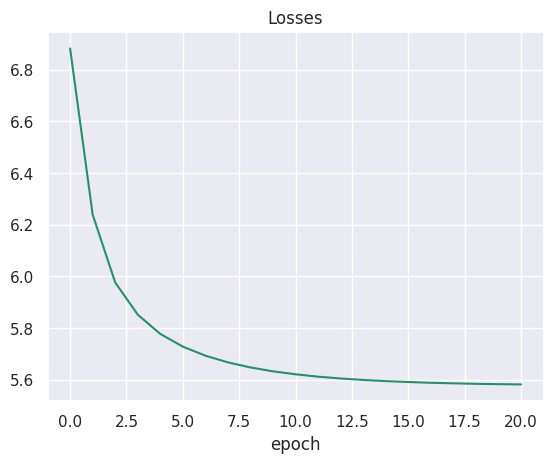

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

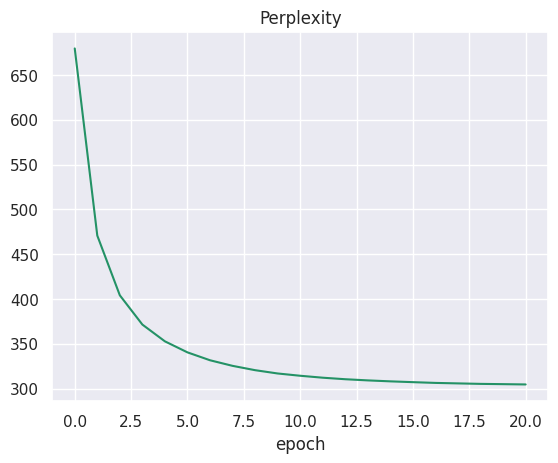

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Эксперимент 2. Модель model_2. LSTM(hidden_dim)

Увеличим размер скрытого состояния hidden_dim=1024

In [ ]:
model_2 = LanguageModel(1024, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities2, losses2 = train_model(
    model_2, criterion, optimizer, scheduler,
    train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

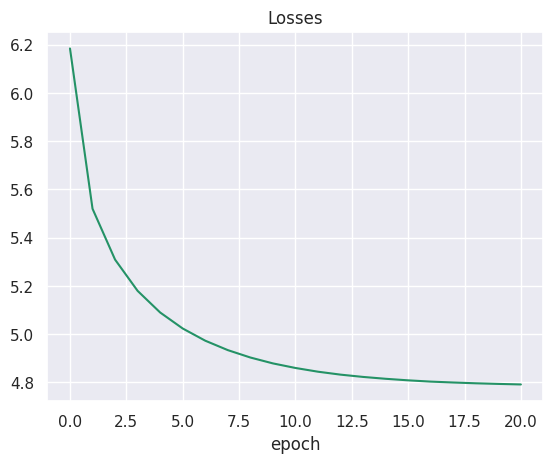

In [ ]:
plt.plot(np.arange(len(losses2)), losses2)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

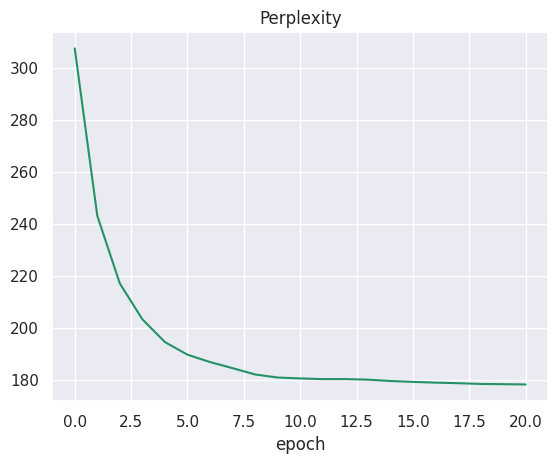

In [ ]:
plt.plot(np.arange(len(perplexities2)), perplexities2)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Эксперимент 3. Baseline модель model_3.

Уменьшим размер скрытого состояния hidden_dim=128

In [ ]:
model_3 = LanguageModel(128, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities3, losses3 = train_model(
    model_3, criterion, optimizer, scheduler,
    train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

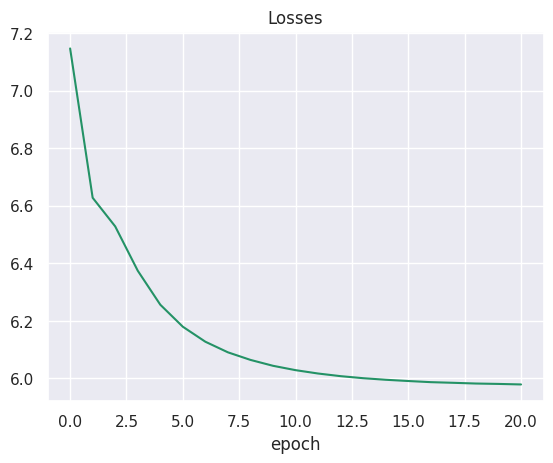

In [ ]:
plt.plot(np.arange(len(losses3)), losses3)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

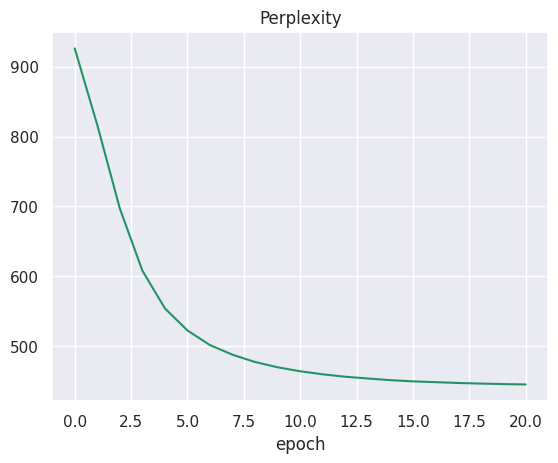

In [ ]:
plt.plot(np.arange(len(perplexities3)), perplexities3)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Эксперимент 4. Baseline модель model_4. LSTM (Linear Layer number change)

Увеличим количество линейных слоев после LSTM

In [ ]:
class LanguageModel_4(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear_up = nn.Linear(hidden_dim, 2 * hidden_dim)
        self.linear_down = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.dropout(self.non_linear(self.linear_up(output)))
        output = self.dropout(self.non_linear(self.linear_down(output)))
        prediction = self.projection(output)

        return prediction

In [ ]:
model_4 = LanguageModel_4(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities4, losses4 = train_model(
    model_4, criterion, optimizer,
    scheduler, train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

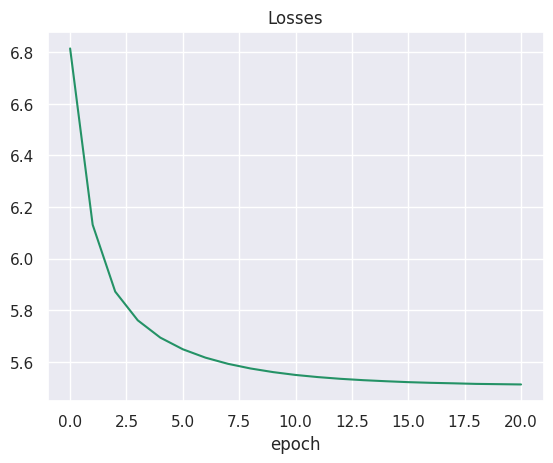

In [ ]:
plt.plot(np.arange(len(losses4)), losses4)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

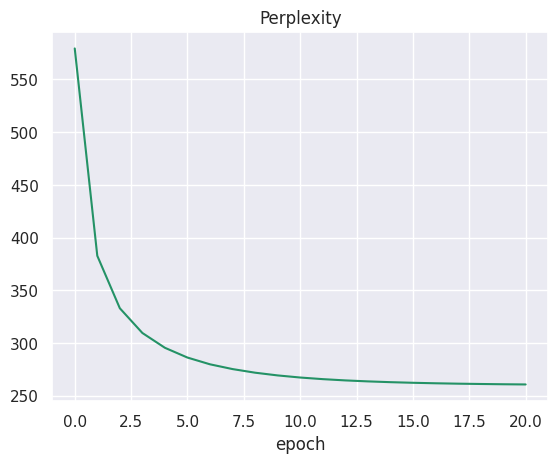

In [ ]:
plt.plot(np.arange(len(perplexities4)), perplexities4)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
result_df = pd.DataFrame({"model": range(4), "min perplexity": [min(perp) for perp in [perplexities, perplexities2,
                                                                                       perplexities3, perplexities4]]}
                        )

In [ ]:
result_df

,model,min perplexity
0,0,304.676831
1,1,178.148457
2,2,445.277199
3,3,260.642307


In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    """
    Реализует метод жадного выбора следующего токена
    """

    # обработка строки starting_seq - приведение к нижнему регистру, удаление знаков препинания
    processed_starting_seq = starting_seq.lower().translate(str.maketrans('', '', string.punctuation))
    device = "cpu"
    model.eval()
    model = model.to(device)
    input_ids = [word2ind["<bos>"]] + [word2ind.get(word, word2ind["<unk>"]) for word in word_tokenize(processed_starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    with torch.no_grad():
        for i in range(max_seq_len):
        # Получает распределение вероятностей для следующего слова от модели:
            next_word_dist = model(input_ids)[-1]
            next_word = next_word_dist.argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind["<eos>"]:
                break

    return ' '.join([ind2word.get(idx) for idx in input_ids.numpy()])

In [ ]:
def generate_sequence_for_each_model(starting_seq):
    print(f"Первые слова: {starting_seq}")
    for i, language_model in enumerate([model, model_2, model_3, model_4], 1):
        print(f"Результат генерации моделью {i}: {generate_sequence(language_model, starting_seq)}")

In [ ]:

generate_sequence_for_each_model("The movie was ")

Первые слова: The movie was 
Результат генерации моделью 1: <bos> the movie was a good movie <eos>
Результат генерации моделью 2: <bos> the movie was a bit more interesting and the acting was very good <eos>
Результат генерации моделью 3: <bos> the movie was a <unk> br the movie is a <unk> <eos>
Результат генерации моделью 4: <bos> the movie was a good movie <eos>


In [ ]:
generate_sequence_for_each_model("We want")

Первые слова: We want
Результат генерации моделью 1: <bos> we want to be a good movie <eos>
Результат генерации моделью 2: <bos> we want to see a movie that is a <unk> <eos>
Результат генерации моделью 3: <bos> we want to be a <unk> <eos>
Результат генерации моделью 4: <bos> we want to see the movie <eos>


In [ ]:
generate_sequence_for_each_model("The best actress")

Первые слова: The best actress
Результат генерации моделью 1: <bos> the best actress is a good movie <eos>
Результат генерации моделью 2: <bos> the best actress in the film is the best of the film <eos>
Результат генерации моделью 3: <bos> the best actress of the movie is a <unk> <eos>
Результат генерации моделью 4: <bos> the best actress is a lot of the movie <eos>


In [ ]:
generate_sequence_for_each_model("I have watched")

Первые слова: I have watched
Результат генерации моделью 1: <bos> i have watched this movie <eos>
Результат генерации моделью 2: <bos> i have watched this movie on dvd and i was very disappointed <eos>
Результат генерации моделью 3: <bos> i have watched the movie <eos>
Результат генерации моделью 4: <bos> i have watched this movie <eos>


In [ ]:
generate_sequence_for_each_model("I like")

Первые слова: I like
Результат генерации моделью 1: <bos> i like this movie <eos>
Результат генерации моделью 2: <bos> i like the movie and i was very disappointed <eos>
Результат генерации моделью 3: <bos> i like the movie is a <unk> <eos>
Результат генерации моделью 4: <bos> i like this movie <eos>


In [ ]:
generate_sequence_for_each_model("hero of that film")

Первые слова: hero of that film
Результат генерации моделью 1: <bos> hero of that film is a good movie <eos>
Результат генерации моделью 2: <bos> hero of that film <eos>
Результат генерации моделью 3: <bos> hero of that film is a <unk> <eos>
Результат генерации моделью 4: <bos> hero of that film is a lot of the movie <eos>


Выводы-

1. Графики изменения перплекции по всем моделям приведены в таблице result_df.  Значения находятся в интервале от 170 до 440.

2.
    1) модель model (baseline модель, hidden_dim=256, Dropout(p=0.2), gamma=0.8, lr=0.0001) генерирует очень простые слова на все рассматриваемые формулировки, вроде 'good movie', но предложения осмысленные.

    2) модель model_2 (baseline модель с повышенным размером скрытого слоя hidden_dim=1024) генерирует самые длинные предложения, имеющие смысл и имеет наиболее низкое значение min перплексии 178.

    3) модель model_3 (baseline модель с пониженным размером скрытого слоя hidden_dim=128) генерирует не очень осмысленные короткие предложения,много <unk>, min перплексия наиболее высокая=440

    4) модель model_4 (baseline модель с увеличенным количеством линейных слоев после LSTM) генерирует предложения либо тикие же простые, как в модели model, либо длинные, но не очень осмысленные


  Есть смысл улучшать параметры вокруг моделей model_2, model_4, что и будет проведено ниже.

3. По всем моделям не достигнуто плато метрики, то есть можно увеличить количество эпох для лучшего результата.

## Вторая группа экспериментов

### Эксперимент 2.1. Модель model_2

Увеличим скорость обучения в model_2 до классической 3e-4, повысим размер скрытого слоя hidden layer до 1536.

In [ ]:
model_2 = LanguageModel(1536, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0003)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities2, losses2 = train_model(
    model_2, criterion, optimizer, scheduler,
    train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

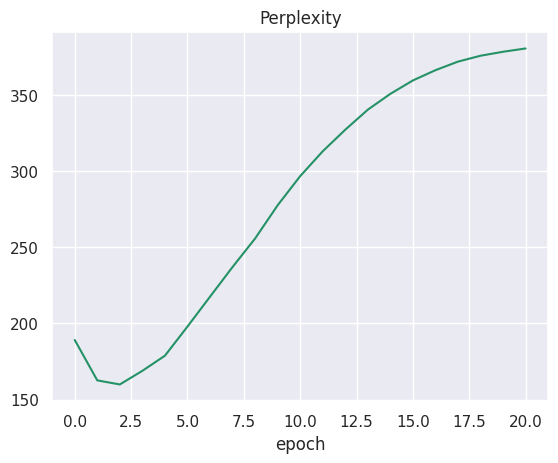

In [ ]:
plt.plot(np.arange(len(perplexities2)), perplexities2)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Эксперимент 2.2 Модель model_3

Дополнительные линейные bottleneck слои (model_4) с увеличенной скоростью обучения 3e-4.

In [ ]:
class LanguageModel_2(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear_up = nn.Linear(hidden_dim, 2 * hidden_dim)
        self.linear_down = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.dropout(self.non_linear(self.linear_up(output)))
        output = self.dropout(self.non_linear(self.linear_down(output)))
        prediction = self.projection(output)

        return prediction

In [ ]:
model_3 = LanguageModel_2(1024, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0003)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities3, losses3 = train_model(
    model_3, criterion, optimizer, scheduler,
    train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

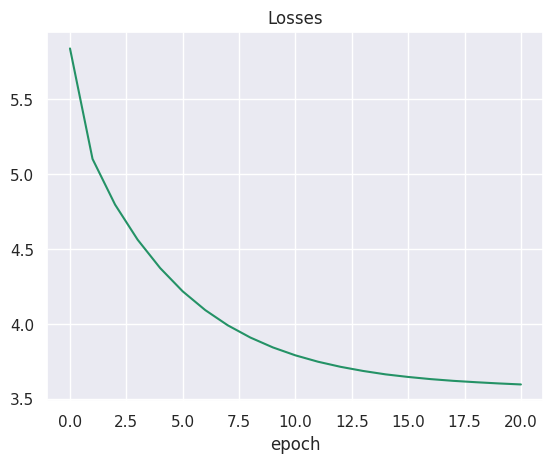

In [ ]:
plt.plot(np.arange(len(losses3)), losses3)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

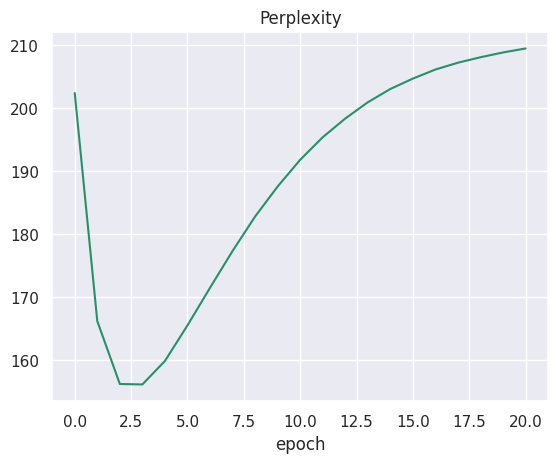

In [ ]:
plt.plot(np.arange(len(perplexities3)), perplexities3)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Эксперимент 2.3. Модель model_4

Дополнительные линейные bottleneck слои (model_4) + увеличение hidden_dim до 1100

In [ ]:
model_4 = LanguageModel_2(1100, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities4, losses4 = train_model(
    model_4, criterion, optimizer,
    scheduler, train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

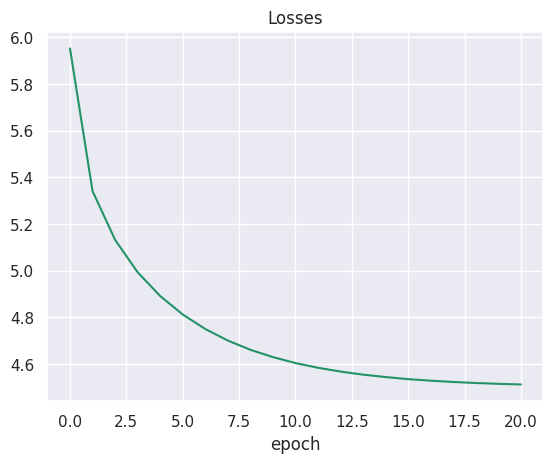

In [ ]:
plt.plot(np.arange(len(losses4)), losses4)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

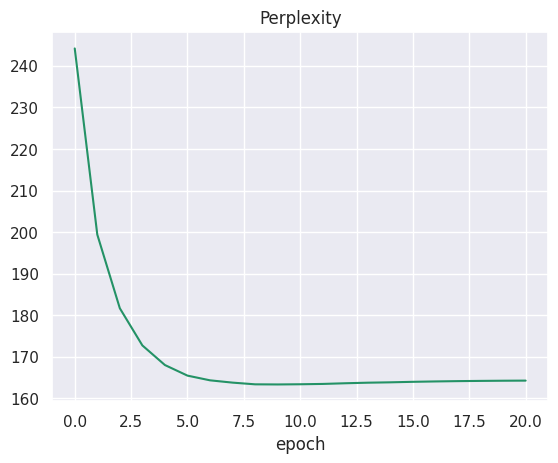

In [ ]:
plt.plot(np.arange(len(perplexities4)), perplexities4)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

## Эксперимент 4. Модель model_5

Делаем LSTM двунаправленной

In [ ]:
class LanguageModel_3(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True  # Включаем двунаправленность
        )

        # Меняем входную размерность linear_up, так как выход LSTM теперь в 2 раза больше
        self.linear_up = nn.Linear(hidden_dim * 2, 2 * hidden_dim)
        self.linear_down = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)

        output = self.dropout(self.non_linear(self.linear_up(output)))
        output = self.dropout(self.non_linear(self.linear_down(output)))
        prediction = self.projection(output)

        return prediction

In [ ]:
model_5 = LanguageModel_3(1024, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [ ]:
perplexities5, losses5 = train_model(
    model_5, criterion, optimizer, scheduler,
    train_dataloader, eval_dataloader, epochs=21
)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

train:   0%|          | 0/1243 [00:00<?, ?it/s]

validation:   0%|          | 0/156 [00:00<?, ?it/s]

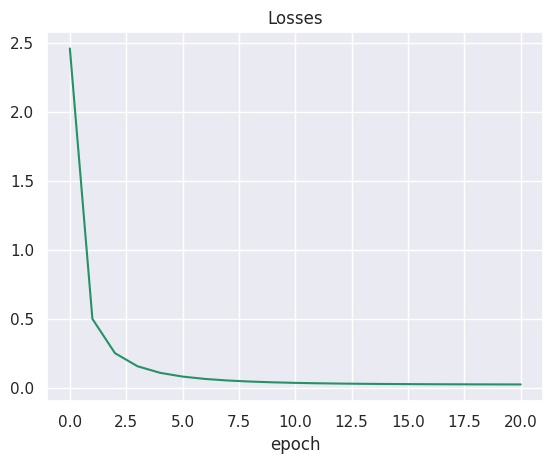

In [ ]:
plt.plot(np.arange(len(losses5)), losses5)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

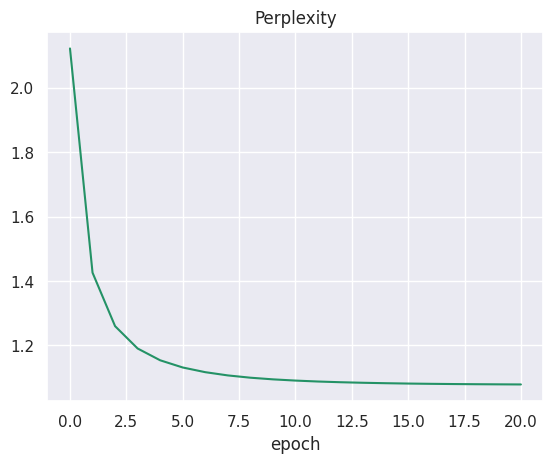

In [ ]:
plt.plot(np.arange(len(perplexities5)), perplexities5)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
result_df = pd.DataFrame({"model": range(4),
                          "min perplexity": [min(perp) for perp in [perplexities2,
                                                                    perplexities3,
                                                                    perplexities4,
                                                                    perplexities5
                          ]]}
                        )

In [ ]:
def generate_sequence_for_each_model(starting_seq):
    print(f"Первые слова: {starting_seq}")
    for i, language_model in enumerate([model_2, model_3, model_4, model_5], 1):
        print(f"Результат генерации моделью {i}: {generate_sequence(language_model, starting_seq)}")

In [ ]:
generate_sequence_for_each_model("The movie was ")

Первые слова: The movie was 
Результат генерации моделью 1: <bos> the movie was so bad i couldnt even finish it <eos>
Результат генерации моделью 2: <bos> the movie was so bad that i had to watch it <eos>
Результат генерации моделью 3: <bos> the movie was a bit slow and i was very disappointed <eos>
Результат генерации моделью 4: <bos> the movie was <eos>


In [ ]:
generate_sequence_for_each_model("We want")

Первые слова: We want
Результат генерации моделью 1: <bos> we want to see the movie <eos>
Результат генерации моделью 2: <bos> we want to see a movie that is going to happen in the end <eos>
Результат генерации моделью 3: <bos> we want to see a good movie with a <unk> <unk> <unk> <unk> <unk> <unk> <eos>
Результат генерации моделью 4: <bos> we want <eos>


In [ ]:
generate_sequence_for_each_model("I have watched")

Первые слова: I have watched
Результат генерации моделью 1: <bos> i have watched this movie many times on tv <eos>
Результат генерации моделью 2: <bos> i have watched this movie twice and i have to say i was very disappointed <eos>
Результат генерации моделью 3: <bos> i have watched this movie a few times and i was surprised to see how it was <eos>
Результат генерации моделью 4: <bos> i have watched <eos>


## Выводы

После обучения первой группы моделей было решено улучшать параметры вокруг  model_2, model_4.

По 2 группе экспериментов результаты следующие:

    1) Модель model_2 представляет улучшенную model_2 из первой группы с увеличенными hidden_dim=1536 и lr=0.0003. Модель показала хорошие резульаты генерации слов по всем 3 примерам и адекватное значение перплекции. График изменения перплексии по эпохам после достижения минимума в начале идет вверх.
    
    2)  Модель model_3 представляет улучшенную model_4 из первой группы с увеличенной lr=0.0003. Модель также показала хорошие резульаты генерации слов по всем 3 примерам и адекватное значение перплекции. График изменения перплексии по эпохам после достижения минимума в начале идет вверх.

    3)  Модель model_4 представляет улучшенную model_4 из первой группы с уменьшенным hidden_dim=1100. Модель генерирует сложные предолжения и слова, но на 1 примере сгенерировала много <unk> подряд. График изменения перплексии по эпохам после достижения минимума в начале идет вверх.

    4)  Модель model_4 представляет улучшенную model_2 из первой группы, но двунаправленную. Модель дает значение перплекции, близкое к идеалу = 1, но по факту модель лишь генерирует 1 символ <eos>.

Итак, лучшими двумя моделями можно считать model_2 и model_3 из 2 группы экспериментов со значениями перплексии, примерно равными 157. Результат генерации слов достаточно осмысленный для достаточно маленького словаря и моделей типа LSTM.

Положительно повлияло на обучение установление размеров рекуррентных слоев в районе hidden_dim=1024 - 1536, установление скорости обучения lr=0.0003, увеличение количества линейных слоев после рекуррентного слоя в 2 раза. Включение двунаправленной LSTM дало невнятный результат.